In [1]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from models import Siamese_SCC
from utils import read_json

### Inspect the model parameters

In [2]:
model_dir = "/mnt/left/jason/model/siamese_cross_subject_model/"
model_list = sorted(os.listdir(model_dir))
cfg = read_json("config/config.json")
model = Siamese_SCC(cfg)
model.load_state_dict(torch.load(model_dir + model_list[0]))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

feat_extractor.Conv_block1.0.weight 	 torch.Size([22, 1, 30, 1])
feat_extractor.Conv_block1.0.bias 	 torch.Size([22])
feat_extractor.Conv_block2.0.weight 	 torch.Size([20, 1, 22, 25])
feat_extractor.Conv_block2.0.bias 	 torch.Size([20])
feat_extractor.regressor.regressor.0.weight 	 torch.Size([1, 20])
feat_extractor.regressor.regressor.0.bias 	 torch.Size([1])
conv_fusion.weight 	 torch.Size([1, 1, 1, 10])
regressor.regressor.0.weight 	 torch.Size([1, 20])
regressor.regressor.0.bias 	 torch.Size([1])
delta_regressor.0.weight 	 torch.Size([1, 20])
delta_regressor.0.bias 	 torch.Size([1])


### Obtain the weights in the spatial filters

In [3]:
spatial_filter_layer = 'feat_extractor.Conv_block1.0.weight'
spatial_weight = model.state_dict()[spatial_filter_layer]
print(f"Size of spatial weight: {spatial_weight.size()}")
avg_spatial_weight = torch.mean(spatial_weight, 0).view(spatial_weight.size(2)).numpy()
avg_spatial_weight

Size of spatial weight: torch.Size([22, 1, 30, 1])


array([-0.02780273, -0.04897248, -0.03574998,  0.0127396 ,  0.05277467,
        0.01776098, -0.01202169, -0.01854607,  0.0554567 ,  0.013623  ,
        0.03683208,  0.01909407,  0.00717979,  0.05315715, -0.01992612,
        0.05202895,  0.04700771, -0.01977816, -0.00019348,  0.04256066,
        0.02484828,  0.00378949, -0.03001825,  0.00297387,  0.00848336,
        0.03708073,  0.01934512, -0.02055985,  0.02566963,  0.02637989],
      dtype=float32)

### Load the positions of electrodes from the raw data

In [4]:
sample_data = "/mnt/left/jason/dataset/s01_061102n.set"
raw = mne.io.read_raw_eeglab(sample_data)
excluded = ['A1', 'A2', 'vehicle position']
new_ch = []
for ch in raw.ch_names:
    if ch not in excluded:
        new_ch.append(ch)

new_info = mne.create_info(ch_names = new_ch, sfreq=raw.info['sfreq'], ch_types=['eeg'] * 30)
raw.info = new_info

# montage data is store in mne package direction
mantage_dir = os.path.join(os.path.dirname(mne.__file__), 'montages')
# choose montage
ten_twenty_montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(ten_twenty_montage, match_case=False)

/tmp/ipykernel_4670/2921394194.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(sample_data)


<RawEEGLAB | s01_061102n.set, 30 x 3152140 (6304.3 s), ~793.7 MB, data loaded>

### Plot the weights on the topoplot

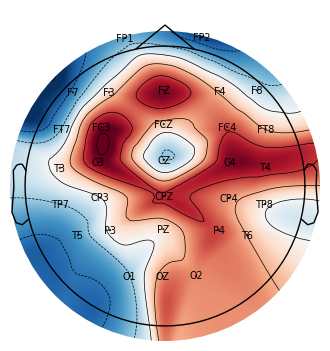

(<matplotlib.image.AxesImage at 0x7f39dd74b700>,
 <matplotlib.contour.QuadContourSet at 0x7f39dd74bb80>)

In [16]:
mne.viz.plot_topomap(avg_spatial_weight, raw.info, names = raw.ch_names, size = 4, res = 81)

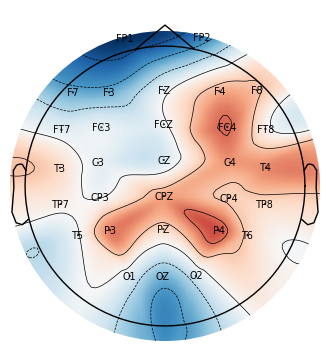

In [3]:
plt.figure()
mne.viz.plot_topomap(overall_spatial_filter, raw.info, names = raw.ch_names, size = 4, res = 81, axes=)

/tmp/ipykernel_4880/2862546495.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(sample_data)


Using matplotlib as 2D backend.


/opt/anaconda3/envs/drowsiness/lib/python3.9/site-packages/mne/viz/topomap.py:812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(figsize=(size, size))


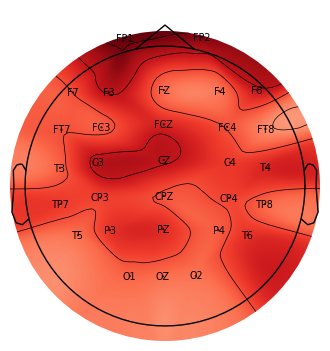

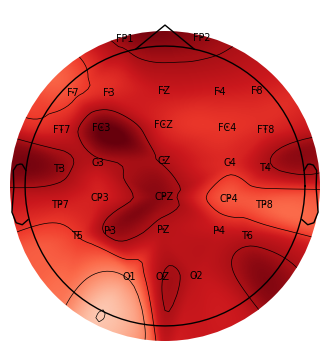

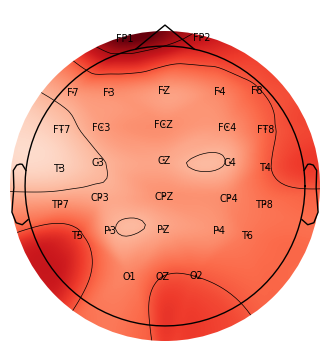

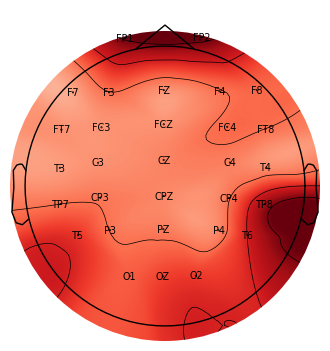

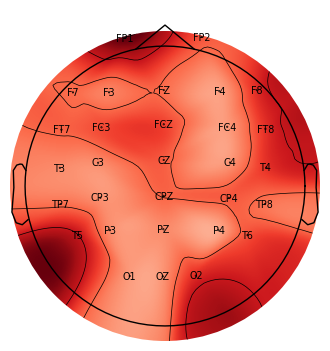

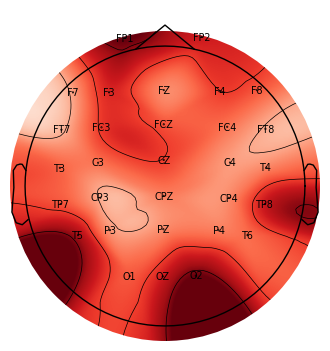

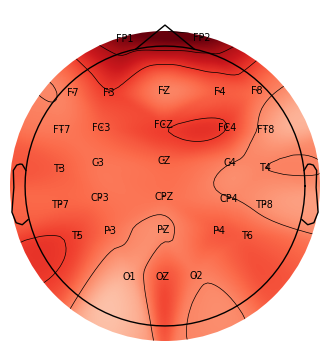

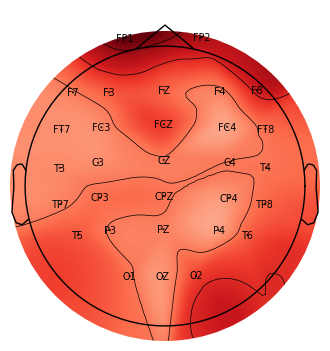

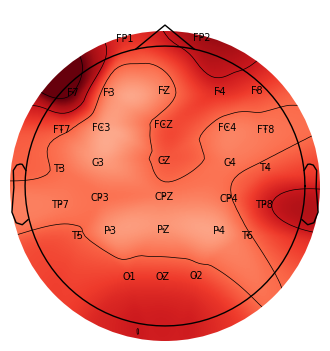

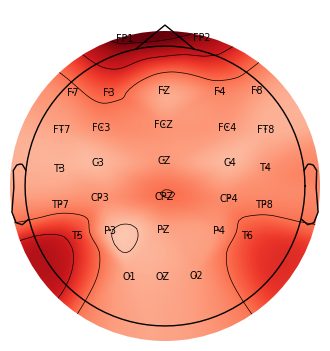

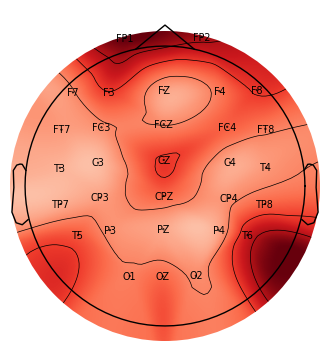

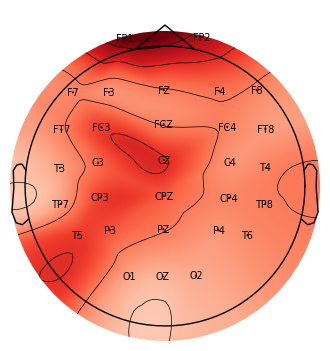

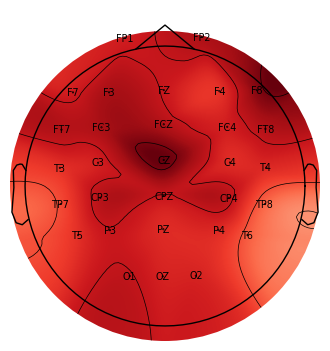

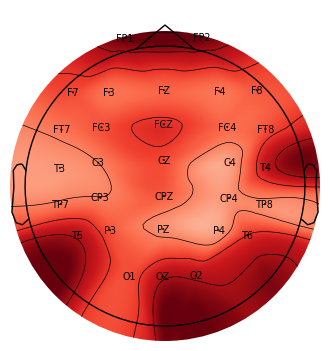

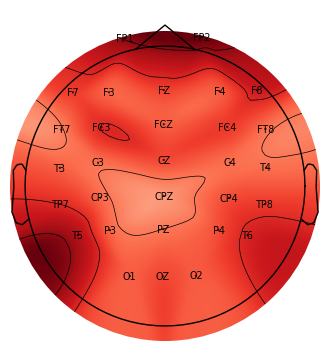

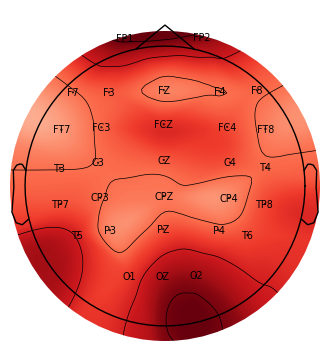

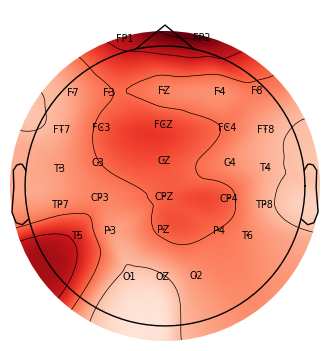

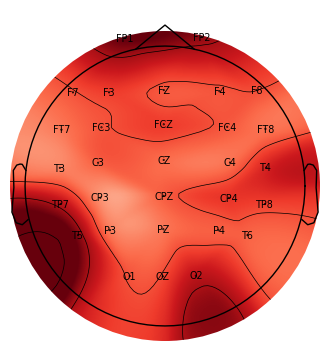

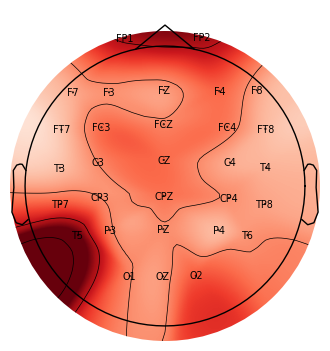

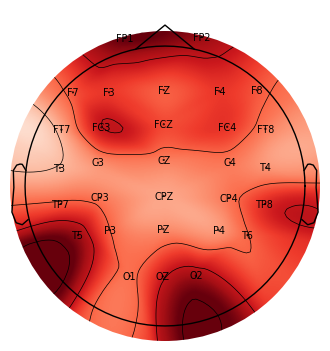

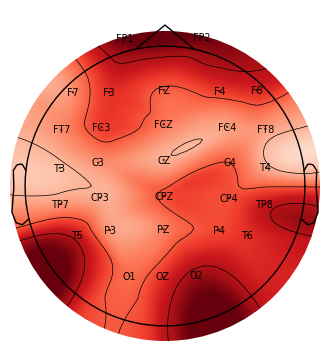

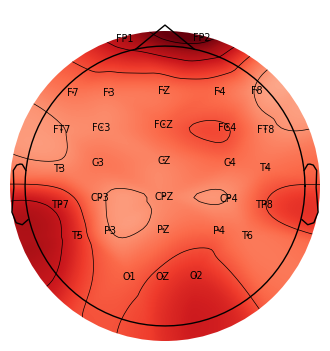

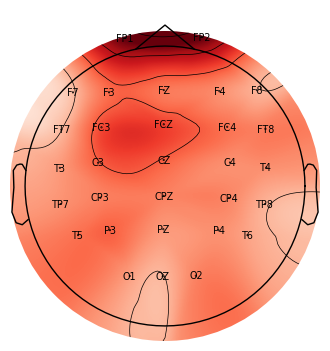

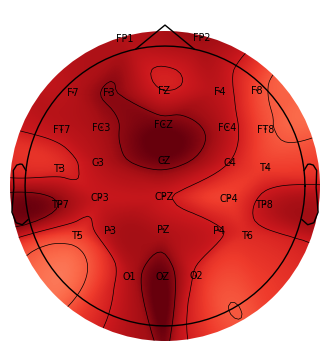

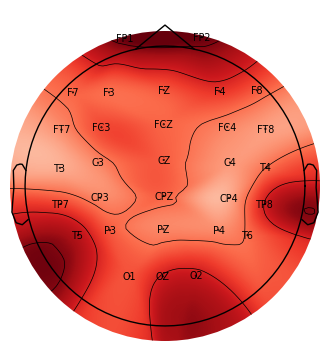

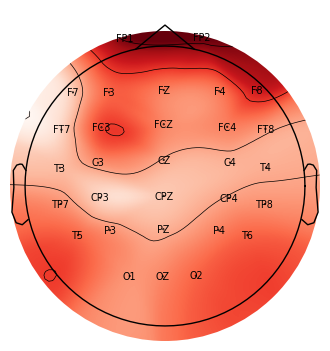

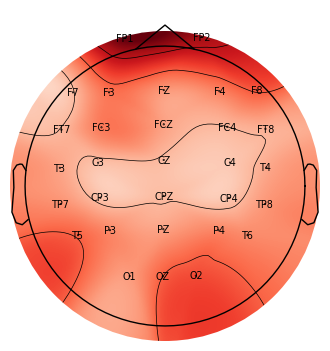

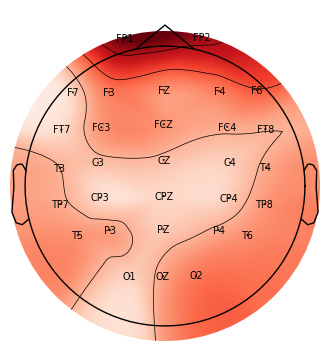

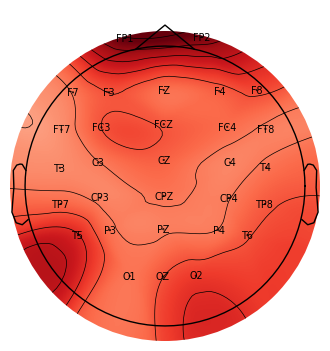

(<matplotlib.image.AxesImage at 0x7fcf08b5d910>,
 <matplotlib.contour.QuadContourSet at 0x7fcf08b5dd30>)

In [2]:
sample_data = "/mnt/left/jason/dataset/s01_061102n.set"
raw = mne.io.read_raw_eeglab(sample_data)
excluded = ['A1', 'A2', 'vehicle position']
new_ch = []
for ch in raw.ch_names:
    if ch not in excluded:
        new_ch.append(ch)

new_info = mne.create_info(ch_names = new_ch, sfreq=raw.info['sfreq'], ch_types=['eeg'] * 30)
raw.info = new_info

# montage data is store in mne package direction
mantage_dir = os.path.join(os.path.dirname(mne.__file__), 'montages')
# choose montage
ten_twenty_montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(ten_twenty_montage, match_case=False)

model_dir = "/mnt/left/jason/model/siamese_cross_subject_model/"
model_list = sorted(os.listdir(model_dir))
overall_spatial_filter = []
for model_path in model_list:
    cfg = read_json("config/config.json")
    model = Siamese_SCC(cfg)
    model.load_state_dict(torch.load(model_dir + model_path))

    spatial_filter_layer = 'feat_extractor.Conv_block1.0.weight'
    spatial_weight = model.state_dict()[spatial_filter_layer]
    avg_spatial_weight = torch.mean(torch.abs(spatial_weight), 0).view(spatial_weight.size(2)).numpy()

    with mne.viz.use_browser_backend('matplotlib'):
        mne.viz.plot_topomap(avg_spatial_weight, raw.info, names = raw.ch_names, contours = 3, size = 4, res = 81, show=False)
        # fig = plt.gcf()
        # fig.savefig(f'{model_path[:-8]}_spatial_filter.png')
        # plt.clf()
    overall_spatial_filter.append(avg_spatial_weight)

overall_spatial_filter = np.stack(overall_spatial_filter)
overall_spatial_filter = np.sum(overall_spatial_filter, 0)
mne.viz.plot_topomap(overall_spatial_filter, raw.info, names = raw.ch_names, size = 4, res = 81)

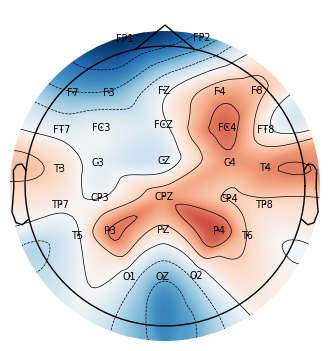

(<matplotlib.image.AxesImage at 0x7f1d80721220>,
 <matplotlib.contour.QuadContourSet at 0x7f1d80721670>)